In [1]:
## This script reports statistics used in the paper

In [2]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import warnings

plt.rc('font', size=14)
warnings.filterwarnings('ignore')

In [3]:
# best = bestAllData.replace(np.inf, 0)
# best = best.fillna(0)

In [4]:
#Load ESCAPE training data
escapeAllData = pd.read_csv("Data/Preprocessed Data/ESCAPE_AllData.csv", sep=",", index_col='ID').sort_index() #all feature dataset
escapeHemo = pd.read_csv("Data/Preprocessed Data/ESCAPE_Hemo.csv", sep=",", index_col='ID').sort_index() #dataset with only hemodynamics
escapeLabels  = pd.read_csv("Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM').sort_index() #labels for prediction classes 
escapeHemoLabels = escapeLabels[escapeLabels.index.isin(escapeHemo.index)]

#Cardiogenic Shock
cardShockHemo = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv", sep=",", index_col='ID').sort_index()
cardShockAllData = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv", sep=",", index_col='ID').sort_index()
cardShockHemoLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoLabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/LabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()

#Serial Cardiac
serialHemo = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv", sep=",", index_col='ID').sort_index()
serialAllData = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv", sep=",", index_col='ID').sort_index()
serialHemoLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/HemoLabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/LabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()

#HF-ACTION
hfactionAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID').sort_index()
hfactionLabels = pd.read_csv("Data Validation/HF-ACTION/Original DataFrames/LabelsHF-ACTION.csv", sep=",", index_col='ID').sort_index()

#BEST
bestAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID').sort_index()
bestLabels = pd.read_csv("Data Validation/BEST/Original DataFrames/LabelsBEST.csv", sep=",", index_col='ID').sort_index()

#Guide it
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID').sort_index()
guideLabels = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/LabelsGUIDE-IT.csv", sep=",", index_col='ID').sort_index()


# # Fix escape labels
escapeAllData.index = (escapeAllData.index.str.rstrip('x')).astype(int)
escapeAllData = escapeAllData.sort_index()


# Adding Calibration Plots

In [5]:
from MVDD import MVDD_Generator as mvgen
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

In [6]:
carna = mvgen.loadMVDDFromFile("TreeFiles/AllData_Death")
dt = carna.model

In [46]:

def getProbs(riskLabels, gTscores):
    risks = riskLabels[~riskLabels.index.duplicated(keep='first')]
    
    probs = []
    for r in risks.values.tolist():
        p = gTscores[r-1]
        probs.append(p)
        
    return probs
    

escapeAllData['ScoreDeath']

ID
72       3
72       3
81       1
81       1
86       3
        ..
99302    1
99912    1
99912    1
99935    3
99935    3
Name: ScoreDeath, Length: 866, dtype: int64

In [45]:
def makeBinaryLabels(labels, preds):
    labels = labels.sort_index()
    preds = preds.sort_index()
    
    labs = []
    for i in preds.index:
        lab = labels.loc[i]
        labs.append(lab)
        
    return labs
        
labs = makeBinaryLabels(escapeLabels['Death'], escapeAllData['ScoreDeath'])
len(labs)

866

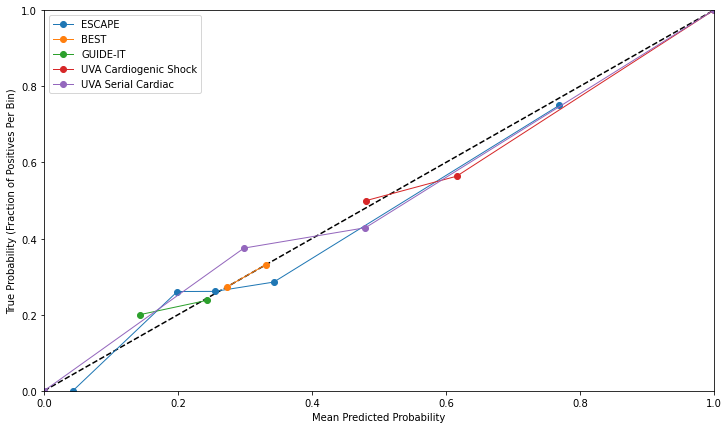

In [8]:
# For All Data Death

gt_escape = [0.199, 0.043, 0.255, 0.7692307692307693, 0.343]
gt_best = [0.33074684772065954, 0.3333333333333333, 0.27483443708609273, 0.0, 0.25925925925925924]
gt_guide = [0.2517985611510791, 0.23504273504273504, 0.23843416370106763, 0.2283464566929134, 0.14285714285714285]
gt_card = [1.0, 1, 0.6309523809523809, 0.48125, 0.607981220657277]
gt_serial = [1.0, 0.29850746268656714, 0.4845360824742268, 0.0, 0.4765625]

n_bins = 10
esc_y, esc_x = calibration_curve(escapeLabels['Death'], getProbs(escapeAllData['ScoreDeath'], gt_escape), n_bins=n_bins)
bst_y, bst_x = calibration_curve(bestLabels['Death'], getProbs(bestAllData['ScoreDeath'], gt_best), n_bins=n_bins)
gd_y, gd_x = calibration_curve(guideLabels['Death'], getProbs(guideAllData['ScoreDeath'], gt_guide), n_bins=n_bins)
cd_y, cd_x = calibration_curve(cardShockLabels['Death'], getProbs(cardShockAllData['ScoreDeath'], gt_card), n_bins=n_bins)
sr_y, sr_x = calibration_curve(serialLabels['Death'], getProbs(serialAllData['ScoreDeath'], gt_serial), n_bins=n_bins)

fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(esc_x,esc_y, marker='o', linewidth=1, label='ESCAPE')
plt.plot(bst_x, bst_y, marker='o', linewidth=1, label='BEST')
plt.plot(gd_x, gd_y, marker='o', linewidth=1, label='GUIDE-IT')
plt.plot(cd_x, cd_y, marker='o', linewidth=1, label='UVA Cardiogenic Shock')
plt.plot(sr_x, sr_y, marker='o', linewidth=1, label='UVA Serial Cardiac')

# plt.title('Calibration plot for All Features - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()
plt.show()


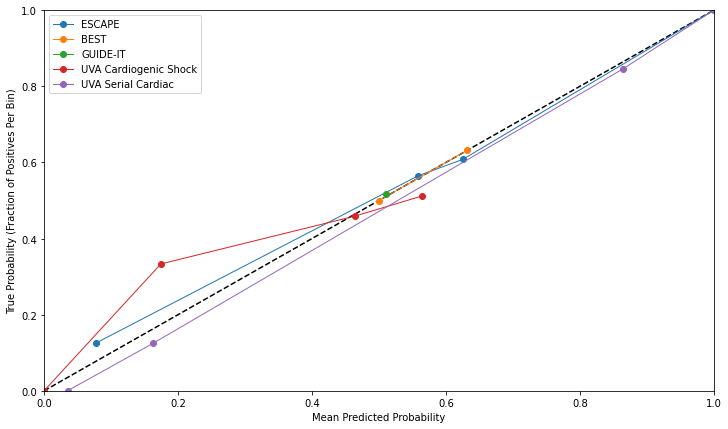

{1, 2, 3, 4, 5}

In [9]:
# For All Data REHOSP

gt_escape = [0.07692307692307693, 1, 0.5587248322147651, 0.6199095022624435, 0.6666666666666666]
gt_best = [0.5, 0.5555555555555556, 0.6319107662463628, 0.6307947019867549, 0.5]
gt_guide = [0.5118110236220472, 0.5299145299145299, 0.5179856115107914, 0.505338078291815, 0.5714285714285714]
gt_card = [0.175, 0.17307692307692307, 0.0, 0.5643192488262911, 0.4643192488262911]
gt_serial = [0.035, 0.163, 1.0, 0.90, 0.8375]

n_bins = 10
esc_y, esc_x = calibration_curve(escapeLabels['Rehosp'], getProbs(escapeAllData['ScoreRehosp'], gt_escape), n_bins=n_bins)
bst_y, bst_x = calibration_curve(bestLabels['Rehosp'], getProbs(bestAllData['ScoreRehosp'], gt_best), n_bins=n_bins)
gd_y, gd_x = calibration_curve(guideLabels['Rehosp'], getProbs(guideAllData['ScoreRehosp'], gt_guide), n_bins=n_bins)
cd_y, cd_x = calibration_curve(cardShockLabels['Rehosp'], getProbs(cardShockAllData['ScoreRehosp'], gt_card), n_bins=n_bins)
sr_y, sr_x = calibration_curve(serialLabels['Rehosp'], getProbs(serialAllData['ScoreRehosp'], gt_serial), n_bins=n_bins)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(esc_x,esc_y, marker='o', linewidth=1, label='ESCAPE')
plt.plot(bst_x, bst_y, marker='o', linewidth=1, label='BEST')
plt.plot(gd_x, gd_y, marker='o', linewidth=1, label='GUIDE-IT')
plt.plot(cd_x, cd_y, marker='o', linewidth=1, label='UVA Cardiogenic Shock')
plt.plot(sr_x, sr_y, marker='o', linewidth=1, label='UVA Serial Cardiac')

# plt.title('Calibration plot for All Features - Rehospitalization')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()
plt.show()

set(serialAllData['Score'])

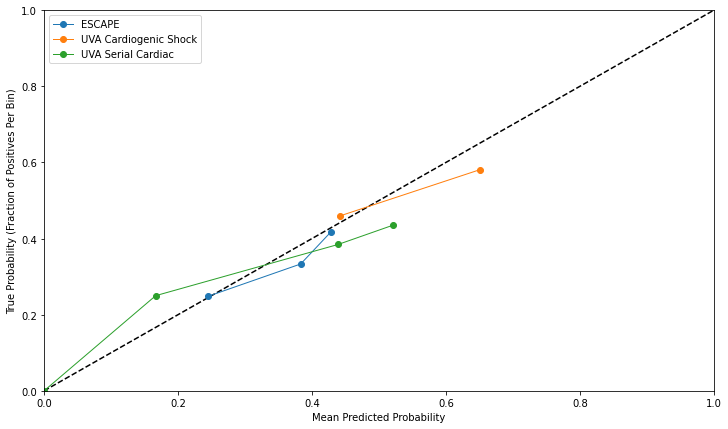

In [23]:
# Hemo Death

# gt_escape = [0.535, 0.041, 0.176, 0.245, 0.364]
# gt_card = [1, 0.45454545454545453, 0.6513761467889908, 0.43103448275862066, 0.45454545454545453]
# gt_serial = [1, 0.36666666666666666,  0.4391891891891892, 0.5246636771300448, 0.5168539325842697]

gt_escape = [0.3897058823529412, 0.37037037037037035, 0.2413793103448276, 0.25, 0.42857142857142855]
gt_card = [0, 0, 0.45454545454545453, 0.6513761467889908, 0.43103448275862066]
gt_serial = [0.16666666666666666, 0.0, 0.4391891891891892, 0.5246636771300448, 0.5168539325842697]

n_bins = 10
esc_y, esc_x = calibration_curve(escapeHemoLabels['Death'], getProbs(escapeHemo['ScoreDeath'], gt_escape), n_bins=n_bins)
cd_y, cd_x = calibration_curve(cardShockHemoLabels['Death'], getProbs(cardShockHemo['ScoreDeath'], gt_card), n_bins=n_bins)
sr_y, sr_x = calibration_curve(serialHemoLabels['Death'], getProbs(serialHemo['ScoreDeath'], gt_serial), n_bins=n_bins)

fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(esc_x,esc_y, marker='o', linewidth=1, label='ESCAPE')
plt.plot(cd_x, cd_y, marker='o', linewidth=1, label='UVA Cardiogenic Shock')
plt.plot(sr_x, sr_y, marker='o', linewidth=1, label='UVA Serial Cardiac')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()
plt.show()


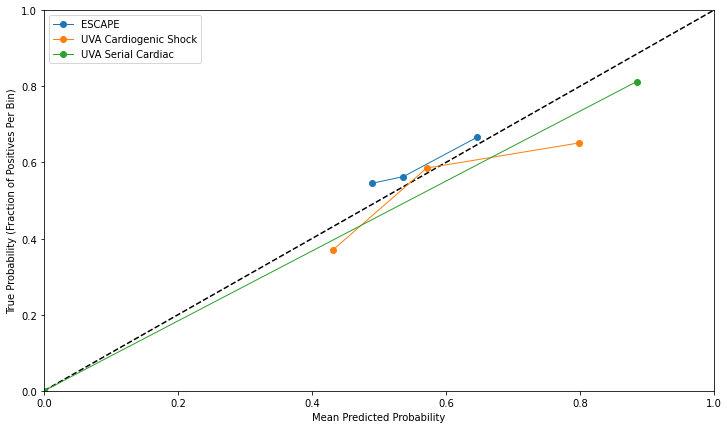

In [42]:
#HEMO REHOSP

gt_escape = [0.4074074074074074, 0.6470588235294118,0.5172413793103449, 0.5520833333333334, 0.5]
gt_card = [0, 0, 0.43103448275862066, 0.5714285714285714, 0.7981651376146789]
gt_serial = [0.0, 0.0, 0.8876404494382022, 0.8716216216216216, 0.8923766816143498]

# ESCAPE
# [0.5, 0.4074074074074074, 0.6470588235294118, 0.5172413793103449, 0.5520833333333334]
# CardShock
# [nan, nan, 0.43103448275862066, 0.5714285714285714, 0.7981651376146789]
# Serial
# [0.0, 0.0, 0.8876404494382022, 0.8716216216216216, 0.8923766816143498]

n_bins = 10
esc_y, esc_x = calibration_curve(escapeHemoLabels['Rehosp'], getProbs(escapeHemo['ScoreRehosp'], gt_escape), n_bins=n_bins)
cd_y, cd_x = calibration_curve(cardShockHemoLabels['Rehosp'], getProbs(cardShockHemo['ScoreRehosp'], gt_card), n_bins=n_bins)
sr_y, sr_x = calibration_curve(serialHemoLabels['Rehosp'], getProbs(serialHemo['ScoreRehosp'], gt_serial), n_bins=n_bins)

fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(esc_x,esc_y, marker='o', linewidth=1, label='ESCAPE')
plt.plot(cd_x, cd_y, marker='o', linewidth=1, label='UVA Cardiogenic Shock')
plt.plot(sr_x, sr_y, marker='o', linewidth=1, label='UVA Serial Cardiac')

# plt.title('Calibration plot for Hemo - Rehosp')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()
plt.show()

In [5]:
# Get Patient Cohort Baseline Characteristics

In [2]:
#Load ESCAPE training data
escapeAllData = pd.read_csv("Data/Original DataFrames/AllDataSingleValue.csv", sep=",", index_col='DEIDNUM').sort_index() #all feature dataset
escapeHemo = pd.read_csv("Data/Original DataFrames/HemoSingleValue.csv", sep=",", index_col='DEIDNUM').sort_index() #dataset with only hemodynamics
escapeLabels  = pd.read_csv("Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM').sort_index() #labels for prediction classes 
escapeHemoLabels = escapeLabels[escapeLabels.index.isin(escapeHemo.index)]

#Cardiogenic Shock
cardShockHemo = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockAllData = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/AllDataCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockHemoLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoLabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/LabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()

#Serial Cardiac
serialHemo = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/HemoSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialAllData = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/AllDataSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialHemoLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/HemoLabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/LabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()

#BEST
bestAllData = pd.read_csv("Data Validation/BEST/Original DataFrames/AllDataBEST.csv", sep=",", index_col='ID').sort_index()
bestLabels = pd.read_csv("Data Validation/BEST/Original DataFrames/LabelsBEST.csv", sep=",", index_col='ID').sort_index()

#Guide it
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/AllDataGUIDE-IT.csv", sep=",", index_col='ID').sort_index()
guideLabels = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/LabelsGUIDE-IT.csv", sep=",", index_col='ID').sort_index()


In [33]:
# guideAllData['BMI'].dropna()

dat = guideAllData[guideAllData['BMI'] != 0]

str(round(dat.describe()['BMI'][1],1)) + "±" + str(round(dat.describe()['BMI'][2],1))

'31.2±8.6'

In [6]:

def getStats(data, labels):
    lst = []
    
    lst.append(len(labels))

    if len(data) == len(labels) * 2:
        lst.append(str(round(data.describe()['Age'][1],1)) + "±" + str(round(data.describe()['Age'][2],1)))
        gen = data['Gender'].value_counts()/2/len(labels)
        lst.append(round(gen[2.0]*100,1))
        gen = data['Race'].value_counts()/2/len(labels)
        lst.append(str(round(gen[1.0]*100,1))+"[" + str(round(gen[2.0]*100,1))+"]")
        lst.append(str(round(data.describe()['BMI'][1],1)) + "±" + str(round(data.describe()['BMI'][2],1)))
        lst.append(str(round(data.describe()['EjF'][1],1)) + "±" + str(round(data.describe()['EjF'][2],1)))
        lst.append(str(round(data.describe()['HR'][1],1)) + "±" + str(round(data.describe()['HR'][2],1)))
        lst.append(str(round(data.describe()['BPSYS'][1],1)) + "±" + str(round(data.describe()['BPSYS'][2],1)))
        lst.append(str(round(data.describe()['BPDIAS'][1],1)) + "±" + str(round(data.describe()['BPDIAS'][2],1)))
        
        lst.append(str(round(data.describe()['CRT'][1],1)) + "±" + str(round(data.describe()['CRT'][2],1)))
        lst.append(str(round(data.describe()['POT'][1],1)) + "±" + str(round(data.describe()['POT'][2],1)))
        lst.append(str(round(data.describe()['BUN'][1],1)) + "±" + str(round(data.describe()['BUN'][2],1)))
        lst.append(str(round(data.describe()['SOD'][1],1)) + "±" + str(round(data.describe()['SOD'][2],1)))

        
    else:
        lst.append(str(round(data.describe()['Age'][1],1)) + "±" + str(round(data.describe()['Age'][2],1)))
        gen = data['Gender'].value_counts()/len(labels)
        lst.append(round(gen[2.0]*100,1))
        gen = data['Race'].value_counts()/len(labels)
        lst.append(str(round(gen[1.0]*100,1))+"[" + str(round(gen[2.0]*100,1))+"]")
        lst.append(str(round(data.describe()['BMI'][1],1)) + "±" + str(round(data.describe()['BMI'][2],1)))
        lst.append(str(round(data.describe()['EjF'][1],1)) + "±" + str(round(data.describe()['EjF'][2],1)))
        lst.append(str(round(data.describe()['HR'][1],1)) + "±" + str(round(data.describe()['HR'][2],1)))
        lst.append(str(round(data.describe()['BPSYS'][1],1)) + "±" + str(round(data.describe()['BPSYS'][2],1)))
        lst.append(str(round(data.describe()['BPDIAS'][1],1)) + "±" + str(round(data.describe()['BPDIAS'][2],1)))
        
        lst.append(str(round(data.describe()['CRT'][1],1)) + "±" + str(round(data.describe()['CRT'][2],1)))
        lst.append(str(round(data.describe()['POT'][1],1)) + "±" + str(round(data.describe()['POT'][2],1)))
        lst.append(str(round(data.describe()['BUN'][1],1)) + "±" + str(round(data.describe()['BUN'][2],1)))
        lst.append(str(round(data.describe()['SOD'][1],1)) + "±" + str(round(data.describe()['SOD'][2],1)))

    lst.append(round(sum(labels['Death']) / len(labels),3))
    try:
        lst.append(round(sum(labels['Rehosp']) / len(labels),3))
    except:
        lst.append("N/A")
    try:
        lst.append(round(sum(labels['Readmission']) / len(labels),3))
    except:
        lst.append("N/A")
        
        
    return lst

def getStatsCath(data, labels):
    lst = []
    lst.append(len(labels))
    lst.append(str(round(data.describe()['Age'][1],1)) + "±" + str(round(data.describe()['Age'][2],1)))
    gen = data['Gender'].value_counts()/3/len(labels)
    lst.append(round(gen[2.0]*100,1))
    lst.append("N/A") #Race
    lst.append(str(round(data.describe()['BMI'][1],1)) + "±" + str(round(data.describe()['BMI'][2],1)))
    lst.append(str(round(data.describe()['EjF'][1],1)) + "±" + str(round(data.describe()['EjF'][2],1)))
    lst.append(str(round(data.describe()['HR'][1],1)) + "±" + str(round(data.describe()['HR'][2],1)))
    lst.append(str(round(data.describe()['BPSYS'][1],1)) + "±" + str(round(data.describe()['BPSYS'][2],1)))
    lst.append(str(round(data.describe()['BPDIAS'][1],1)) + "±" + str(round(data.describe()['BPDIAS'][2],1)))
    
    lst.append(str(round(data.describe()['CRT'][1],1)) + "±" + str(round(data.describe()['CRT'][2],1)))
    lst.append(str(round(data.describe()['POT'][1],1)) + "±" + str(round(data.describe()['POT'][2],1)))
    lst.append(str(round(data.describe()['BUN'][1],1)) + "±" + str(round(data.describe()['BUN'][2],1)))
    lst.append(str(round(data.describe()['SOD'][1],1)) + "±" + str(round(data.describe()['SOD'][2],1)))


    lst.append(round(sum(labels['Death']) / len(labels),3))
    lst.append(round(sum(labels['Rehosp']) / len(labels),3))
    lst.append("N/A")
        
    return lst
    

df = pd.DataFrame(index=["n", "Age (years)", "Gender (%, female)", "Race (%, white[minority])", "BMI", "EF", "HR", "BPSYS", "BPDIAS", "CRT", "POT", "BUN", "SOD", "Death", "Rehosp", "Readm"])
df['ESCAPE'] = getStats(escapeAllData, escapeLabels)
df['BEST'] = getStats(bestAllData, bestLabels)
df['GUIDE-IT'] = getStats(guideAllData, guideLabels)
df['UVA Cardiogenic Shock'] = getStatsCath(cardShockAllData, cardShockLabels)
df['UVA Serial Cath'] = getStatsCath(serialAllData, serialLabels)


# df = pd.DataFrame(bigLst, columns=['idx','ESCAPE', 'HF-ACTION']).set_index("idx")
df

,ESCAPE,BEST,GUIDE-IT,UVA Cardiogenic Shock,UVA Serial Cath
n,433,2707,388,364,183
Age (years),56.1±13.9,60.2±12.3,62.2±13.9,59.4±18.5,60.6±15.1
"Gender (%, female)",25.9,21.9,66.2,35.2,43.2
"Race (%, white[minority])",59.6[40.4],70.0[30.0],49.2[50.8],N/A,N/A
BMI,28.4±6.7,0.0±0.0,15.4±16.7,29.8±8.8,30.5±8.0
EF,19.3±6.6,23.0±7.3,24.0±8.2,31.7±17.4,31.3±18.0
HR,80.8±14.9,0.0±0.0,0.0±0.0,0.0±0.0,0.0±0.0
BPSYS,103.7±15.8,118.5±19.4,115.4±20.0,111.1±21.9,109.1±21.4
BPDIAS,64.1±11.5,71.9±11.7,70.2±13.5,62.2±15.5,59.9±17.2
CRT,6.7±34.0,1.2±0.4,1.6±0.7,1.7±1.3,1.7±1.0


In [7]:
serialAllData['BMI'].max()

56.1

In [8]:
## Get Percent Data missing

In [9]:
def getMissing(misData):
    return sum(misData.isnull().sum()) / (misData.shape[0] * misData.shape[1]) * 100

In [10]:
# All Data
print("ESCAPE:", round(getMissing(escapeAllData),1))
print("BEST:", round(getMissing(bestAllData),1))
print("GUIDE IT:", round(getMissing(guideAllData),1))
print("Card Shock:", round(getMissing(cardShockAllData),1))
print("Serial:", round(getMissing(serialAllData),1))


ESCAPE: 7.8
BEST: 2.0
GUIDE IT: 15.1
Card Shock: 10.4
Serial: 7.3


In [11]:
# Hemo
print("ESCAPE:", round(getMissing(escapeHemo),1))
print("Card Shock:", round(getMissing(cardShockHemo),1))
print("Serial:", round(getMissing(serialHemo),1))

ESCAPE: 12.0
Card Shock: 5.9
Serial: 9.2


# Get confidence intervals for training data

In [12]:
# Helper functions
# Return 95% Confidence Interval for Value
def CI(val, n):
    ci = 1.96 * math.sqrt(abs(val - (1 - val)) / n)
    #return ci
    return str(val) + " +/- " + str(round(ci,3))

In [13]:
# Hemo - DeLvTx
print("Accuracy", CI(0.957, len(escapeHemo)))
print("AUC", CI(0.952, len(escapeHemo)))
print("Sens", CI(0.936, len(escapeHemo)))
print("Spec", CI(0.968, len(escapeHemo)))

Accuracy 0.957 +/- 0.092
AUC 0.952 +/- 0.091
Sens 0.936 +/- 0.09
Spec 0.968 +/- 0.093


In [14]:
# Hemo - Rehosp
print("Accuracy", CI(0.961, len(escapeHemo)))
print("AUC", CI(0.956, len(escapeHemo)))
print("Sens", CI(0.942, len(escapeHemo)))
print("Spec", CI(0.970, len(escapeHemo)))

Accuracy 0.961 +/- 0.092
AUC 0.956 +/- 0.092
Sens 0.942 +/- 0.09
Spec 0.97 +/- 0.093


In [15]:
# All Features - DeLvTx
print("Accuracy", CI(0.994, len(escapeAllData)))
print("AUC", CI(0.978, len(escapeAllData)))
print("Sens", CI(0.963, len(escapeAllData)))
print("Spec", CI(0.994, len(escapeAllData)))

Accuracy 0.994 +/- 0.066
AUC 0.978 +/- 0.065
Sens 0.963 +/- 0.064
Spec 0.994 +/- 0.066


In [16]:
# All Features - Rehosp
print("Accuracy", CI(0.994, len(escapeAllData)))
print("AUC", CI(0.975, len(escapeAllData)))
print("Sens", CI(0.958, len(escapeAllData)))
print("Spec", CI(0.994, len(escapeAllData)))

Accuracy 0.994 +/- 0.066
AUC 0.975 +/- 0.065
Sens 0.958 +/- 0.064
Spec 0.994 +/- 0.066


# Get Cluster Outcome Percentages

In [17]:
escapeAllData

escapeLabels

,Death,Rehosp,Readmission
DEIDNUM,,,
72,1,1,0
81,0,1,0
86,0,0,0
267,1,0,0
814,0,0,0
...,...,...,...
98078,0,1,0
98508,0,0,0
99302,1,1,0


In [18]:
def addOutcomes(df, labs):
    dth = []
    rhp = []
    for idx in df.index:
        dth.append(labs.loc[idx]['Death'])
        rhp.append(labs.loc[idx]['Rehosp'])

    df['Death'] = dth
    df['Rehosp'] = rhp

    return df
    
def getOutPers(df, outcome):
    lst = []
    for i in range(1, 6):
        cls = df[df['Score' + outcome] == i]
        
        lst.append(cls[outcome].mean())
        
    print(lst)
        

In [19]:
sc

''

In [20]:
# HEMO
escH = pd.read_csv('Data/Preprocessed Data/ESCAPE_Hemo.csv', index_col='ID')
escH = addOutcomes(escH, escapeHemoLabels)

cs = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv", sep=",", index_col='ID')
cs = addOutcomes(cs, cardShockHemoLabels)

sc = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv", sep=",", index_col='ID')
sc = addOutcomes(sc, serialHemoLabels)

#esc 2, cs 3, serial 3
print("ESCAPE")
getOutPers(escH, "Death")
print("CardShock")
getOutPers(cs, "Death")
print("Serial")
getOutPers(sc, "Death")

print("\n")
print("ESCAPE")
getOutPers(escH, "Rehosp")
print("CardShock")
getOutPers(cs, "Rehosp")
print("Serial")
getOutPers(sc, "Rehosp")

ESCAPE
[0.42857142857142855, 0.37037037037037035, 0.2413793103448276, 0.25, 0.3897058823529412]
CardShock
[nan, nan, 0.45454545454545453, 0.6513761467889908, 0.43103448275862066]
Serial
[0.16666666666666666, 0.0, 0.4391891891891892, 0.5246636771300448, 0.5168539325842697]


ESCAPE
[0.5, 0.4074074074074074, 0.6470588235294118, 0.5172413793103449, 0.5520833333333334]
CardShock
[nan, nan, 0.43103448275862066, 0.5714285714285714, 0.7981651376146789]
Serial
[0.0, 0.0, 0.8876404494382022, 0.8716216216216216, 0.8923766816143498]


In [21]:
# All Data
escAD = pd.read_csv("Data/Preprocessed Data/ESCAPE_AllData.csv", sep=",", index_col='ID').sort_index() #all feature dataset
labs = copy.deepcopy(escapeLabels)
labs.index = labs.index.astype(str) + "x"
labs = labs.sort_index()

escAD = addOutcomes(escAD, labs)
escAD

bst = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
bst = addOutcomes(bst, bestLabels)

gd = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
gd = addOutcomes(gd, guideLabels)


cs = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv", sep=",", index_col='ID')
cs = addOutcomes(cs, cardShockLabels)

sc = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv", sep=",", index_col='ID')
sc = addOutcomes(sc, serialLabels)

#esc 2, bst 1, gd 3, cs 3, serial 3
print("ESCAPE")
getOutPers(escAD, "Death")
print("BEST")
getOutPers(bst, "Death")
print("GUIDE")
getOutPers(gd, "Death")
print("CardShock")
getOutPers(cs, "Death")
print("Serial")
getOutPers(sc, "Death")

print("\n")
print("ESCAPE")
getOutPers(escAD, "Rehosp")
print("BEST")
getOutPers(bst, "Rehosp")
print("GUIDE")
getOutPers(gd, "Rehosp")
print("CardShock")
getOutPers(cs, "Rehosp")
print("Serial")
getOutPers(sc, "Rehosp")

ESCAPE
[0.2651006711409396, 0.3333333333333333, 0.2579185520361991, 0.7692307692307693, 0.24242424242424243]
BEST
[0.33074684772065954, 0.3333333333333333, 0.27483443708609273, 0.0, 0.25925925925925924]
GUIDE
[0.2517985611510791, 0.23504273504273504, 0.23843416370106763, 0.2283464566929134, 0.14285714285714285]
CardShock
[1.0, 0.5, 0.6309523809523809, 0.48125, 0.607981220657277]
Serial
[1.0, 0.29850746268656714, 0.4845360824742268, 0.2553191489361702, 0.4765625]


ESCAPE
[0.07692307692307693, 0.3333333333333333, 0.5587248322147651, 0.6199095022624435, 0.6666666666666666]
BEST
[0.5, 0.5555555555555556, 0.6319107662463628, 0.6307947019867549, 0.5]
GUIDE
[0.5118110236220472, 0.5299145299145299, 0.5179856115107914, 0.505338078291815, 0.5714285714285714]
CardShock
[0.175, 0.17307692307692307, 0.0, 0.75, 0.6643192488262911]
Serial
[0.46808510638297873, 0.3283582089552239, 1.0, 0.9381443298969072, 0.9375]


In [22]:
# All Data
escAD = pd.read_csv("Data/Preprocessed Data/ESCAPE_AllData.csv", sep=",", index_col='ID').sort_index() #all feature dataset
labs = copy.deepcopy(escapeLabels)
labs.index = labs.index.astype(str) + "x"
labs = labs.sort_index()

escAD = addOutcomes(escAD, labs)
escAD

bst = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
bst = addOutcomes(bst, bestLabels)

gd = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
gd = addOutcomes(gd, guideLabels)


cs = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv", sep=",", index_col='ID')
cs = addOutcomes(cs, cardShockLabels)

sc = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv", sep=",", index_col='ID')
sc = addOutcomes(sc, serialLabels)

#esc 2, bst 1, gd 3, cs 3, serial 3
print("ESCAPE")
getOutPers(escAD, "Death")
print("BEST")
getOutPers(bst, "Death")
print("GUIDE")
getOutPers(gd, "Death")
print("CardShock")
getOutPers(cs, "Death")
print("Serial")
getOutPers(sc, "Death")

print("\n")
print("ESCAPE")
getOutPers(escAD, "Rehosp")
print("BEST")
getOutPers(bst, "Rehosp")
print("GUIDE")
getOutPers(gd, "Rehosp")
print("CardShock")
getOutPers(cs, "Rehosp")
print("Serial")
getOutPers(sc, "Rehosp")

ESCAPE
[0.2651006711409396, 0.3333333333333333, 0.2579185520361991, 0.7692307692307693, 0.24242424242424243]
BEST
[0.33074684772065954, 0.3333333333333333, 0.27483443708609273, 0.0, 0.25925925925925924]
GUIDE
[0.2517985611510791, 0.23504273504273504, 0.23843416370106763, 0.2283464566929134, 0.14285714285714285]
CardShock
[1.0, 0.5, 0.6309523809523809, 0.48125, 0.607981220657277]
Serial
[1.0, 0.29850746268656714, 0.4845360824742268, 0.2553191489361702, 0.4765625]


ESCAPE
[0.07692307692307693, 0.3333333333333333, 0.5587248322147651, 0.6199095022624435, 0.6666666666666666]
BEST
[0.5, 0.5555555555555556, 0.6319107662463628, 0.6307947019867549, 0.5]
GUIDE
[0.5118110236220472, 0.5299145299145299, 0.5179856115107914, 0.505338078291815, 0.5714285714285714]
CardShock
[0.175, 0.17307692307692307, 0.0, 0.75, 0.6643192488262911]
Serial
[0.46808510638297873, 0.3283582089552239, 1.0, 0.9381443298969072, 0.9375]


# Plot Training Averaged AUC Graphs

In [23]:
from sklearn.metrics import auc

In [24]:
# Compute micro-average ROC curve and ROC area
fpr = 0.027
tpr = 0.946
roc = auc(fpr, tpr)

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot and save averaged AUC graph
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 18})
plt.plot(fpr, tpr,
     label='Averaged AUC: {0:0.3f}'
           ''.format(roc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.legend(loc="lower right")

TypeError: Expected sequence or array-like, got <class 'float'>

In [ ]:
from sklearn.metrics import auc

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr = 0.027
tpr = 0.946
roc = auc(fpr, tpr)

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot and save averaged AUC graph
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 18})
plt.plot(fpr, tpr,
     label='Averaged AUC: {0:0.3f}'
           ''.format(roc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.legend(loc="lower right")

# Get Outcome Percentages Based on Cluster Group

In [ ]:
#Load ESCAPE training data
escapeAllData = pd.read_csv("Data/Preprocessed Data/ESCAPE_AllData.csv", sep=",", index_col='ID').sort_index() #all feature dataset
escapeHemo = pd.read_csv("Data/Preprocessed Data/ESCAPE_Hemo.csv", sep=",", index_col='ID').sort_index() #dataset with only hemodynamics
escapeLabels  = pd.read_csv("Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM').sort_index() #labels for prediction classes 
escapeHemoLabels = escapeLabels[escapeLabels.index.isin(escapeHemo.index)]

#Cardiogenic Shock
cardShockHemo = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv", sep=",", index_col='ID').sort_index()
cardShockAllData = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv", sep=",", index_col='ID').sort_index()
cardShockHemoLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoLabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/LabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()

#Serial Cardiac
serialHemo = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv", sep=",", index_col='ID').sort_index()
serialAllData = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv", sep=",", index_col='ID').sort_index()
serialHemoLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/HemoLabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/LabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()

#HF-ACTION
hfactionAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID').sort_index()
hfactionLabels = pd.read_csv("Data Validation/HF-ACTION/Original DataFrames/LabelsHF-ACTION.csv", sep=",", index_col='ID').sort_index()

#BEST
bestAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID').sort_index()
bestLabels = pd.read_csv("Data Validation/BEST/Original DataFrames/LabelsBEST.csv", sep=",", index_col='ID').sort_index()

#Guide it
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID').sort_index()
guideLabels = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/LabelsGUIDE-IT.csv", sep=",", index_col='ID').sort_index()


In [ ]:
def getPercentOutcome(dataset, labels, outcome, risk):
    cluster = dataset.loc[dataset['Score' + outcome] == risk ]
    labelMatches = labels[labels.index.isin(cluster.index)]
    per = labelMatches[outcome].mean()
    return per


In [ ]:
risks = [5, 4, 3, 2, 1]
lst = []
outcome = 'Death'
for r in risks:
    per1 = getPercentOutcome(escapeHemo, escapeHemoLabels, outcome, r)
    per2 = getPercentOutcome(cardShockHemo, cardShockHemoLabels, outcome, r)
    per3 = getPercentOutcome(serialHemo, serialHemoLabels, outcome, r)
    lst.append([r, per1, per2, per3])
    
df = pd.DataFrame(lst, columns = ['Cluster', 'ESCAPE', 'Card Shock', 'Serial']).set_index('Cluster')
print(df.mean(axis=1))
df.T


In [ ]:
risks = [5, 4, 3, 2, 1]
lst = []
outcome = 'Rehosp'
for r in risks:
    per1 = getPercentOutcome(escapeHemo, escapeLabels, outcome, r)
#     per2 = getPercentOutcome(cardShockHemo, cardShockHemoLabels, outcome, r)
#     per3 = getPercentOutcome(serialHemo, serialHemoLabels, outcome, r)
    lst.append([r, per1, per2, per3])
    
df = pd.DataFrame(lst, columns = ['Cluster', 'ESCAPE', 'Card Shock', 'Serial']).set_index('Cluster')
print(df.mean(axis=1))
df.T

## All Data

In [ ]:
risks = [5, 4, 3, 2, 1]
lst = []
outcome = 'Death'
for r in risks:
    per1 = getPercentOutcome(escapeAllData, escapeLabels, outcome, r)
    per2 = getPercentOutcome(cardShockAllData, cardShockLabels, outcome, r)
    per3 = getPercentOutcome(serialAllData, serialLabels, outcome, r)
    per4 = getPercentOutcome(hfactionAllData, hfactionLabels, outcome, r)
    per5 = getPercentOutcome(bestAllData, bestLabels, outcome, r)
    per6 = getPercentOutcome(guideAllData, guideLabels, outcome, r)
    lst.append([r, per1, per2, per3, per4, per5, per6])
    
df = pd.DataFrame(lst, columns = ['Cluster', 'ESCAPE', 'Card Shock', 'Serial', 'HF-ACTION', 'BEST', 'GUIDE']).set_index('Cluster')
print(df.mean(axis=1))
df.T

In [ ]:
risks = [5, 4, 3, 2, 1]
lst = []
outcome = 'Rehosp'
for r in risks:
    per1 = getPercentOutcome(escapeAllData, escapeLabels, outcome, r)
#     per2 = getPercentOutcome(cardShockAllData, cardShockLabels, outcome, r)
#     per3 = getPercentOutcome(serialAllData, serialLabels, outcome, r)
    per4 = getPercentOutcome(hfactionAllData, hfactionLabels, outcome, r)
    per5 = getPercentOutcome(bestAllData, bestLabels, outcome, r)
    per6 = getPercentOutcome(guideAllData, guideLabels, outcome, r)
    lst.append([r, per1,  per4, per5, per6])
    
df = pd.DataFrame(lst, columns = ['Cluster', 'ESCAPE',  'HF-ACTION', 'BEST', 'GUIDE']).set_index('Cluster')
print(df.mean(axis=1))
df.T

In [ ]:
risks = [5, 4, 3, 2, 1]
lst = []
outcome = 'Readmission'
for r in risks:
    per1 = getPercentOutcome(escapeAllData, escapeLabels, outcome, r)
#     per2 = getPercentOutcome(cardShockAllData, cardShockLabels, outcome, r)
#     per3 = getPercentOutcome(serialAllData, serialLabels, outcome, r)
    per4 = getPercentOutcome(hfactionAllData, hfactionLabels, outcome, r)
#     per5 = getPercentOutcome(bestAllData, bestLabels, outcome, r)
#     per6 = getPercentOutcome(guideAllData, guideLabels, outcome, r)
    lst.append([r, per1,  per4, ])
    
df = pd.DataFrame(lst, columns = ['Cluster', 'ESCAPE',  'HF-ACTION']).set_index('Cluster')
print(df.mean(axis=1))
df.T

# Get Outcome Percentages Based on Cluster Group

In [ ]:
#Load ESCAPE training data
escapeAllData = pd.read_csv("Data/Preprocessed Data/ESCAPE_AllData.csv", sep=",", index_col='ID').sort_index() #all feature dataset
escapeHemo = pd.read_csv("Data/Preprocessed Data/ESCAPE_Hemo.csv", sep=",", index_col='ID').sort_index() #dataset with only hemodynamics
escapeLabels  = pd.read_csv("Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM').sort_index() #labels for prediction classes 
escapeHemoLabels = escapeLabels[escapeLabels.index.isin(escapeHemo.index)]

#Cardiogenic Shock
cardShockHemo = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv", sep=",", index_col='ID').sort_index()
cardShockAllData = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv", sep=",", index_col='ID').sort_index()
cardShockHemoLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoLabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/LabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()

#Serial Cardiac
serialHemo = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv", sep=",", index_col='ID').sort_index()
serialAllData = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv", sep=",", index_col='ID').sort_index()
serialHemoLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/HemoLabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/LabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()

#HF-ACTION
hfactionAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID').sort_index()
hfactionLabels = pd.read_csv("Data Validation/HF-ACTION/Original DataFrames/LabelsHF-ACTION.csv", sep=",", index_col='ID').sort_index()

#BEST
bestAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID').sort_index()
bestLabels = pd.read_csv("Data Validation/BEST/Original DataFrames/LabelsBEST.csv", sep=",", index_col='ID').sort_index()

#Guide it
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID').sort_index()
guideLabels = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/LabelsGUIDE-IT.csv", sep=",", index_col='ID').sort_index()


In [ ]:
def getPercentOutcome(dataset, labels, outcome, risk):
    cluster = dataset.loc[dataset['Score' + outcome] == risk ]
    labelMatches = labels[labels.index.isin(cluster.index)]
    per = labelMatches[outcome].mean()
    return per


In [ ]:
risks = [5, 4, 3, 2, 1]
lst = []
outcome = 'Death'
for r in risks:
    per1 = getPercentOutcome(escapeHemo, escapeHemoLabels, outcome, r)
    per2 = getPercentOutcome(cardShockHemo, cardShockHemoLabels, outcome, r)
    per3 = getPercentOutcome(serialHemo, serialHemoLabels, outcome, r)
    lst.append([r, per1, per2, per3])
    
df = pd.DataFrame(lst, columns = ['Cluster', 'ESCAPE', 'Card Shock', 'Serial']).set_index('Cluster')
print(df.mean(axis=1))
df.T


In [ ]:
risks = [5, 4, 3, 2, 1]
lst = []
outcome = 'Rehosp'
for r in risks:
    per1 = getPercentOutcome(escapeHemo, escapeLabels, outcome, r)
#     per2 = getPercentOutcome(cardShockHemo, cardShockHemoLabels, outcome, r)
#     per3 = getPercentOutcome(serialHemo, serialHemoLabels, outcome, r)
    lst.append([r, per1, per2, per3])
    
df = pd.DataFrame(lst, columns = ['Cluster', 'ESCAPE', 'Card Shock', 'Serial']).set_index('Cluster')
print(df.mean(axis=1))
df.T

## All Data

In [ ]:
risks = [5, 4, 3, 2, 1]
lst = []
outcome = 'Death'
for r in risks:
    per1 = getPercentOutcome(escapeAllData, escapeLabels, outcome, r)
    per2 = getPercentOutcome(cardShockAllData, cardShockLabels, outcome, r)
    per3 = getPercentOutcome(serialAllData, serialLabels, outcome, r)
    per4 = getPercentOutcome(hfactionAllData, hfactionLabels, outcome, r)
    per5 = getPercentOutcome(bestAllData, bestLabels, outcome, r)
    per6 = getPercentOutcome(guideAllData, guideLabels, outcome, r)
    lst.append([r, per1, per2, per3, per4, per5, per6])
    
df = pd.DataFrame(lst, columns = ['Cluster', 'ESCAPE', 'Card Shock', 'Serial', 'HF-ACTION', 'BEST', 'GUIDE']).set_index('Cluster')
print(df.mean(axis=1))
df.T

In [ ]:
risks = [5, 4, 3, 2, 1]
lst = []
outcome = 'Rehosp'
for r in risks:
    per1 = getPercentOutcome(escapeAllData, escapeLabels, outcome, r)
#     per2 = getPercentOutcome(cardShockAllData, cardShockLabels, outcome, r)
#     per3 = getPercentOutcome(serialAllData, serialLabels, outcome, r)
    per4 = getPercentOutcome(hfactionAllData, hfactionLabels, outcome, r)
    per5 = getPercentOutcome(bestAllData, bestLabels, outcome, r)
    per6 = getPercentOutcome(guideAllData, guideLabels, outcome, r)
    lst.append([r, per1,  per4, per5, per6])
    
df = pd.DataFrame(lst, columns = ['Cluster', 'ESCAPE',  'HF-ACTION', 'BEST', 'GUIDE']).set_index('Cluster')
print(df.mean(axis=1))
df.T

In [ ]:
risks = [5, 4, 3, 2, 1]
lst = []
outcome = 'Readmission'
for r in risks:
    per1 = getPercentOutcome(escapeAllData, escapeLabels, outcome, r)
#     per2 = getPercentOutcome(cardShockAllData, cardShockLabels, outcome, r)
#     per3 = getPercentOutcome(serialAllData, serialLabels, outcome, r)
    per4 = getPercentOutcome(hfactionAllData, hfactionLabels, outcome, r)
#     per5 = getPercentOutcome(bestAllData, bestLabels, outcome, r)
#     per6 = getPercentOutcome(guideAllData, guideLabels, outcome, r)
    lst.append([r, per1,  per4, ])
    
df = pd.DataFrame(lst, columns = ['Cluster', 'ESCAPE',  'HF-ACTION']).set_index('Cluster')
print(df.mean(axis=1))
df.T

In [ ]:
test = pd.read_csv("Data/Preprocessed Data/ESCAPE_AllData.csv", sep=",", index_col='ID').sort_index() #all feature dataset
test

In [ ]:
plt.hist(test['ScoreDeath'])